In [1]:
# Martin Konečnik, https://git.siwim.si/machine-learning/fix-qa-binary-classification
# Notebook intended for prototyping binary classification models
import tomllib
from pathlib import Path

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from swm import factory
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Read the configuration file.
with open('conf.toml', 'rb') as f:
    conf = tomllib.load(f)

EVENTS_PATH = Path().home() / conf['data_dir'] / 'prepared'
INDEX = conf['channel']

In [3]:
# Build a list of training data.
signals_unaltered = []
signals_corrected = []
binary_labels = []
for event in (EVENTS_PATH / 'unaltered' / '0').iterdir():
    data = factory.read_file(event)
    signals_unaltered.append(data.acqdata.a[INDEX].data)

for event in (EVENTS_PATH / 'corrected' / '0').iterdir():
    data = factory.read_file(event)
    signals_corrected.append(data.acqdata.a[INDEX].data)

print(f'Unaltered signals: {len(signals_unaltered)}')
print(f'Corrected signals: {len(signals_corrected)}')

signals = signals_unaltered + signals_corrected
binary_labels = np.array([0] * len(signals_unaltered) + [1] * len(signals_corrected))

max_length = max(len(signal) for signal in signals)

signals = np.array([np.pad(signal, (0, max_length - len(signal))) for signal in signals])
binary_labels = np.array(binary_labels)

print(f'Original signals shape: {signals.shape}')
print(f'Binary labels shape: {binary_labels.shape}')  # Must be 1D.

Unaltered signals: 60309
Corrected signals: 1192
Original signals shape: (61501, 4329)
Binary labels shape: (61501,)


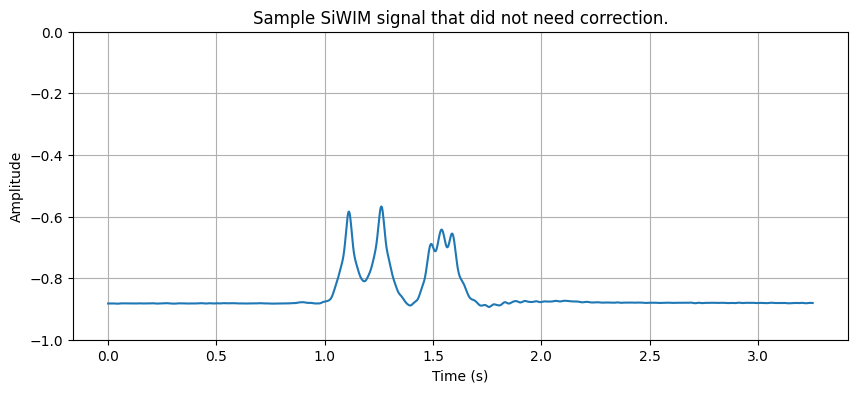

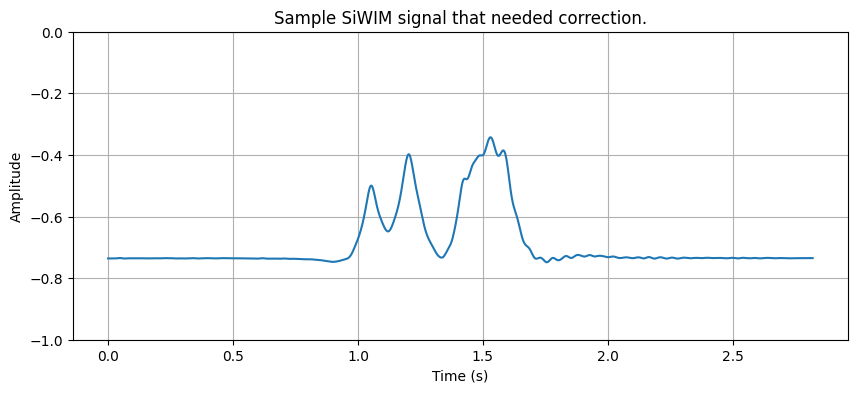

In [20]:
# Sample signal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(signals_unaltered[0])) / 512, signals_unaltered[0], label='0')
plt.title('Sample SiWIM signal that did not need correction.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-1, 0)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(signals_corrected[2])) / 512, signals_corrected[2], label='0')
plt.title('Sample SiWIM signal that needed correction.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-1, 0)
plt.grid(True)
plt.show()

In [49]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(signals, binary_labels, test_size=0.2, stratify=binary_labels)  # Stratify makes sure the random split preserves ratio of classes.

In [50]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()  # float32 for features
y_train_tensor = torch.from_numpy(y_train).long()  # int64 for labels
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Prepare DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Sanity check
sample_X, sample_y = next(iter(train_loader))
print(f'Final training batch - X shape: {sample_X.shape}, y shape: {sample_y.shape}')
print(f'X dtype: {sample_X.dtype}, y dtype: {sample_y.dtype}')  # Should be float32 and int.

Final training batch - X shape: torch.Size([32, 4329]), y shape: torch.Size([32])
X dtype: torch.float32, y dtype: torch.int64


In [84]:
# Initialize model, loss function and optimizer.
from classifier import BinaryClassifier

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(binary_labels), y=binary_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights[0]  # For consistent ratio normalize first value to 1.

print(f'Class ratio {class_weights[0]} : {class_weights[1]}')

model = BinaryClassifier(max_length)
criterion = torch.nn.BCEWithLogitsLoss(weight=class_weights[1])  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Class ratio 1.0 : 50.59479904174805


In [85]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  # Update loss.

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')

Epoch 1, Loss: 35.0778
Epoch 2, Loss: 35.0696
Epoch 3, Loss: 35.0696
Epoch 4, Loss: 35.0696
Epoch 5, Loss: 35.0696
Epoch 6, Loss: 35.0696
Epoch 7, Loss: 35.0696
Epoch 8, Loss: 35.0696
Epoch 9, Loss: 35.0696
Epoch 10, Loss: 35.0696


In [86]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.07%


In [87]:
from cestel_helpers.version import get_version

ver = get_version()

model_path = Path(f'models/{ver}')
model_path.mkdir(exist_ok=True, parents=True)

# Save model
torch.save(model.state_dict(), model_path / 'fix-qa-binary-classification.pth')

# Save dimensions
with open(model_path / 'dimensions', 'w') as f:
    f.write(str(max_length))